In [395]:
%pwd

'/Users/sven/gh/fullstack-ml-academy-homework/notepads/05-Explorative-Datenanalyse'

## Descriptive Statistics

### Lageparameter
- Arithmetisches Mittel / Durchschnitt / average
- Getrimmtes Mittel / truncated mean
- Gewichtetes Mittel / weighted arithmetic mean
- Median

### Streuungsmaße
- Spannweite / range
- Mittlere Absolute Abweichung / mean absolute deviation
- Varianz / variance
- Standardabweichung / standard deviation
- Quantil, Perzentil, Quartil
- Interquartilsabstand / Spannweite vom Perzentil 25 zum Perzentil 75 / interquartil range
- Variationskoeffizient
- Empirischer Quartilsdispersionskoeffizient

### Verteilungen
- Boxplot
- Histogram
- Dichtediagramm

### Zusammenhangmaße
- Korrelationskoeffizient
- Korrelationsmatrix
- Streudiagramm
- Streudiagramm-Matrix
- Predictive Power Score


In [396]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pandas as pd
import numpy as np
from scipy import stats


In [397]:
from inspect import signature


def curry(fn):
    """
    Decorator to curry any function.

    Parameters
    ----------
    f : function
        A function to curry.

    Returns
    -------
    fn(...) : object
        The result or a curried function. Depending on the number of parameters given.
    """
    num_args = len(signature(fn).parameters)
    def init(*args, **kwargs):
      def call(*more_args, **more_kwargs):
        all_args = args + more_args
        all_kwargs = dict(**kwargs, **more_kwargs)
        if len(all_args) + len(all_kwargs) >= num_args:
          return fn(*all_args, **all_kwargs)
        else:
          return init(*all_args, **all_kwargs)
      return call
    return init()

In [398]:
pd.options.display.float_format = '{:.0f}'.format
data = pd.read_csv("../../data/Census-Datensatz.csv", sep=';', skipinitialspace=True)

df = data.copy()

df.drop(['fnlwgt'],axis=1,inplace=True)

#cleaning string in object columns
for i in df.columns:
    if df[i].dtype=='object':
        df[i] = df[i].str.strip()


In [399]:
df.describe(include='all')

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,NaN,9,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,39,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,1078,87,40,NaN,NaN
std,14,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,7385,403,12,NaN,NaN
min,17,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0,0,1,NaN,NaN
25%,28,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,0,0,40,NaN,NaN
50%,37,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,0,0,40,NaN,NaN
75%,48,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,0,0,45,NaN,NaN


In [400]:
df['age'].value_counts()

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: age, Length: 73, dtype: int64

In [401]:
df['hours-per-week'].value_counts()

40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
82        1
92        1
87        1
74        1
94        1
Name: hours-per-week, Length: 94, dtype: int64

In [402]:
def is_greater_than_zero(x: int) -> bool:
    b: bool = x > 0
    return b

@curry
def as_int(f, x) -> int:
    """
    Effectively int(f(x)).

    Parameters
    ----------
    f : function
        A function to call.
    x : object
        Value to pass to the function f as the only parameter.

    Returns
    -------
    int(f(x)) : int
        The result as an int.
    """
    y = f(x)
    return int(y)

is_greater_than_zero_as_int = as_int(is_greater_than_zero)

df['capital_gain_present'] = df['capital-gain'].map(is_greater_than_zero_as_int)
df['capital_loss_present'] = df['capital-loss'].map(is_greater_than_zero_as_int)
df = df.assign(capital_gain_and_loss_present=lambda x: x.capital_gain_present & x.capital_loss_present)

df.describe(percentiles=[.05, .10, .25, .5, .75, .90, .95, .96, .97, .98, .99])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   age                            32561 non-null  int64 
 1   workclass                      32561 non-null  object
 2   education                      32561 non-null  object
 3   education-num                  32561 non-null  int64 
 4   marital-status                 32561 non-null  object
 5   occupation                     32561 non-null  object
 6   relationship                   32561 non-null  object
 7   race                           32561 non-null  object
 8   sex                            32561 non-null  object
 9   capital-gain                   32561 non-null  int64 
 10  capital-loss                   32561 non-null  int64 
 11  hours-per-week                 32561 non-null  int64 
 12  native-country                 32561 non-null  object
 13  i

In [403]:
df['capital_gain_present'].value_counts()

0    29849
1     2712
Name: capital_gain_present, dtype: int64

In [404]:
df['capital_loss_present'].value_counts()

0    31042
1     1519
Name: capital_loss_present, dtype: int64

In [405]:
df['capital_gain_and_loss_present'].value_counts()

0    32561
Name: capital_gain_and_loss_present, dtype: int64

In [406]:
# retain only some of the numeric columns
numeric_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
df_numeric = df[numeric_columns]
# add column income_cat
income_column = ['income']
income_data = df[income_column]
income_data_codes = income_data.income.astype('category').cat.codes
df_numeric['income-cat'] = income_data_codes
# sort by age
df_sorted = df_numeric.sort_values(by='capital-gain', ascending=True)
# ensure datatype int32
df_int = df_sorted.astype('int32')
# data_int.describe(percentiles=[.05, .10, .25, .5, .75, .90, .95, .96, .97, .98, .99]).apply('{:.0f}'.format)
# raises error with message unsupported format string passed to Series.__format__
# so instead we use pd.options.display.float_format = '{:.0f}'.format right after importing pandas
df_int.describe(include='all', percentiles=[.05, .10, .25, .5, .75, .90, .95, .96, .97, .98, .99])

/var/folders/h2/lkcg_8md1x38x9b_fv91s7pw0000gn/T/ipykernel_4420/3782906034.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['income-cat'] = income_data_codes


,age,capital-gain,capital-loss,hours-per-week,income-cat
count,32561,32561,32561,32561,32561
mean,39,1078,87,40,0
std,14,7385,403,12,0
min,17,0,0,1,0
5%,19,0,0,18,0
10%,22,0,0,24,0
25%,28,0,0,40,0
50%,37,0,0,40,0
75%,48,0,0,45,0
90%,58,0,0,55,1


In [407]:
print(df_int.median(numeric_only=True))

age              37
capital-gain      0
capital-loss      0
hours-per-week   40
income-cat        0
dtype: float64


In [408]:
print(df_int.mean(numeric_only=True))

age                39
capital-gain     1078
capital-loss       87
hours-per-week     40
income-cat          0
dtype: float64


In [409]:
print(df_int.mode(numeric_only=True, dropna=True))

   age  capital-gain  capital-loss  hours-per-week  income-cat
0   36             0             0              40           0


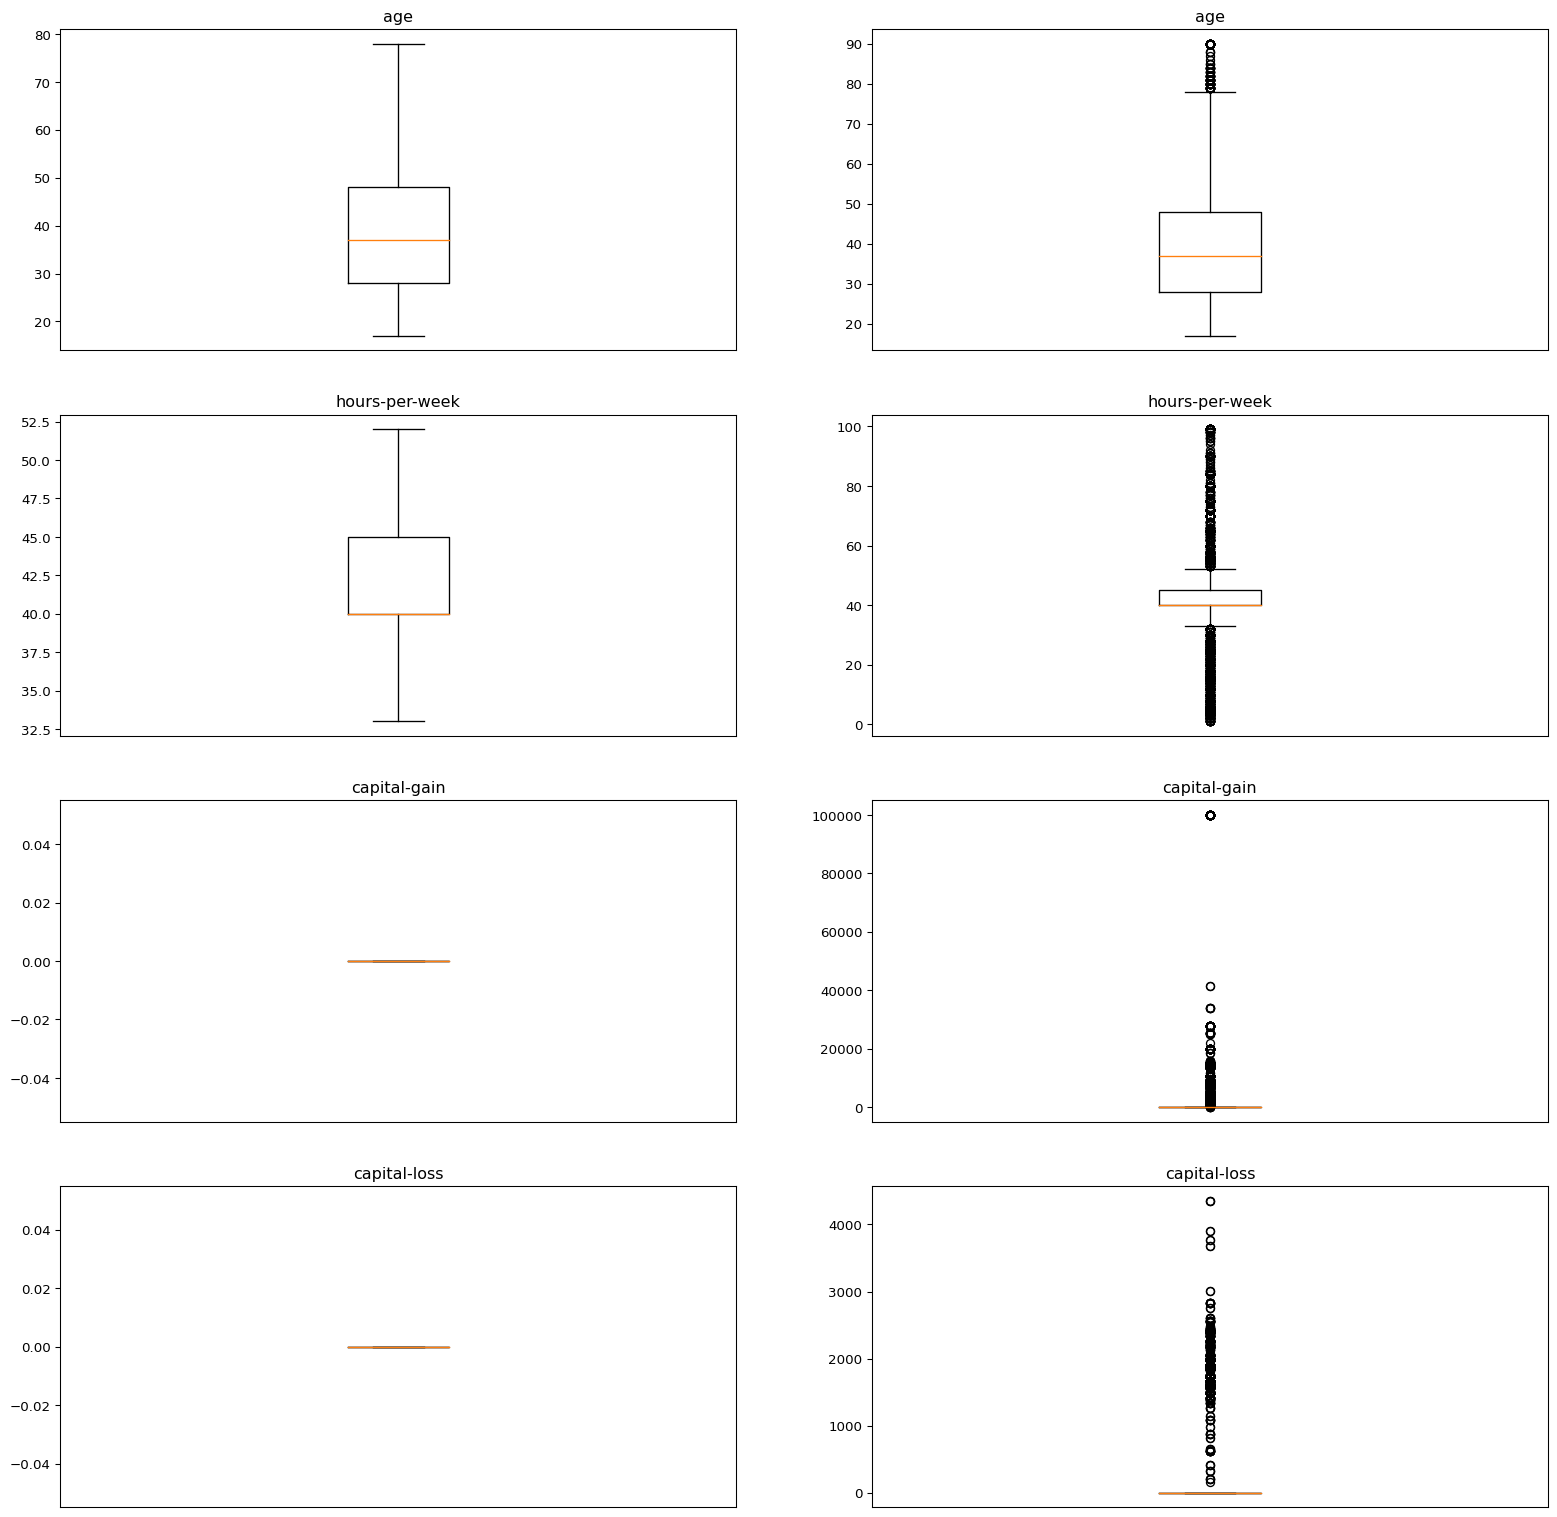

In [410]:
fig, axs = plt.subplots(4, 2)

axs[0, 0].boxplot(df_int['age'], showfliers=False)
axs[0, 0].set_title('age')
axs[0, 1].boxplot(df_int['age'], showfliers=True)
axs[0, 1].set_title('age')
axs[1, 0].boxplot(df_int['hours-per-week'], showfliers=False)
axs[1, 0].set_title('hours-per-week')
axs[1, 1].boxplot(df_int['hours-per-week'], showfliers=True)
axs[1, 1].set_title('hours-per-week')
axs[2, 0].boxplot(df_int['capital-gain'], showfliers=False)
axs[2, 0].set_title('capital-gain')
axs[2, 1].boxplot(df_int['capital-gain'], showfliers=True)
axs[2, 1].set_title('capital-gain')
axs[3, 0].boxplot(df_int['capital-loss'], showfliers=False)
axs[3, 0].set_title('capital-loss')
axs[3, 1].boxplot(df_int['capital-loss'], showfliers=True)
axs[3, 1].set_title('capital-loss')

for ax in axs.ravel():
    #ax.set_xticks([])
    ax.xaxis.set_major_locator(plt.NullLocator())

fig.set_size_inches(20.0, 20.0)
fig.set_dpi(96.0)


array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='capital-gain', ylabel='age'>,
        <Axes: xlabel='capital-loss', ylabel='age'>,
        <Axes: xlabel='hours-per-week', ylabel='age'>,
        <Axes: xlabel='income-cat', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='capital-gain'>,
        <Axes: xlabel='capital-gain', ylabel='capital-gain'>,
        <Axes: xlabel='capital-loss', ylabel='capital-gain'>,
        <Axes: xlabel='hours-per-week', ylabel='capital-gain'>,
        <Axes: xlabel='income-cat', ylabel='capital-gain'>],
       [<Axes: xlabel='age', ylabel='capital-loss'>,
        <Axes: xlabel='capital-gain', ylabel='capital-loss'>,
        <Axes: xlabel='capital-loss', ylabel='capital-loss'>,
        <Axes: xlabel='hours-per-week', ylabel='capital-loss'>,
        <Axes: xlabel='income-cat', ylabel='capital-loss'>],
       [<Axes: xlabel='age', ylabel='hours-per-week'>,
        <Axes: xlabel='capital-gain', ylabel='hours-per-week'>,
        <Axes: xlabe

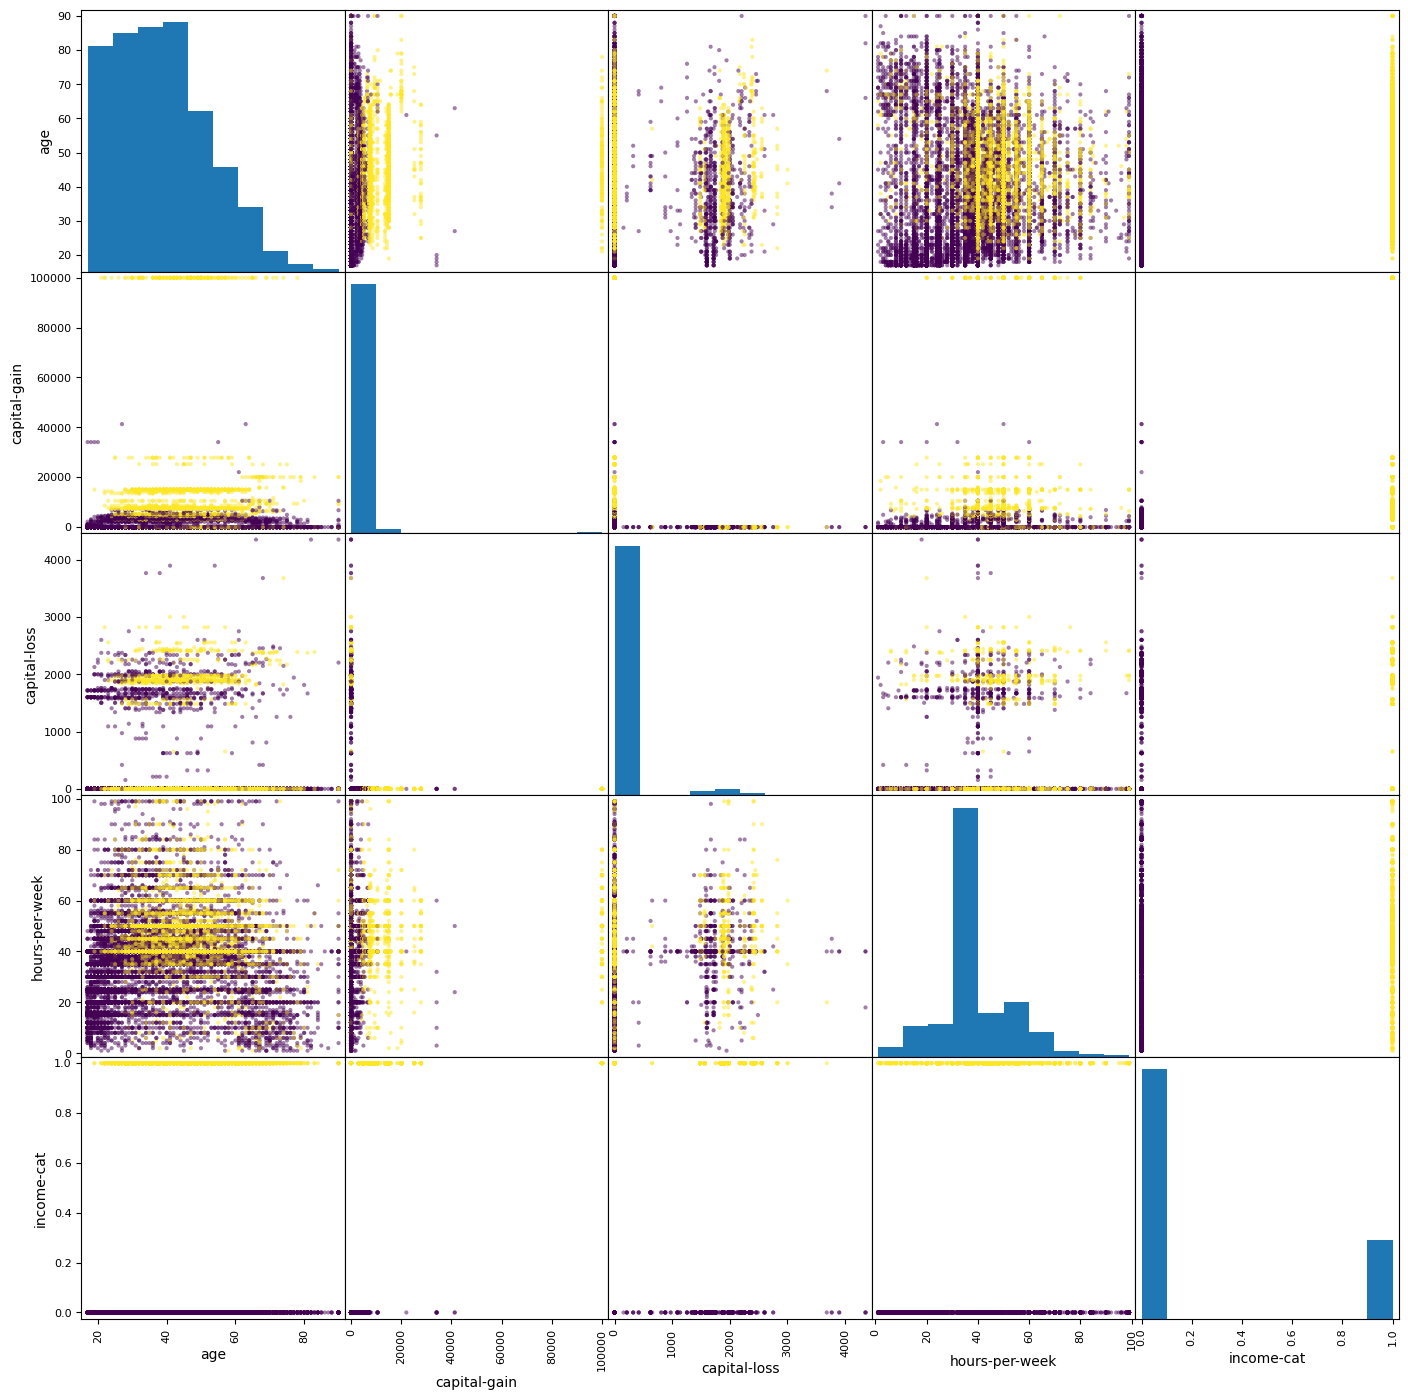

In [411]:
pd.plotting.scatter_matrix(df_int, 
                           c=df_int['income-cat'], 
                           figsize=(17, 17)
                          )